In [1]:
import pulse2percept as p2p
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

2017-08-07 20:14:42,967 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
axonal_tracts = p2p.retina.grow_axons(n_axons=200)

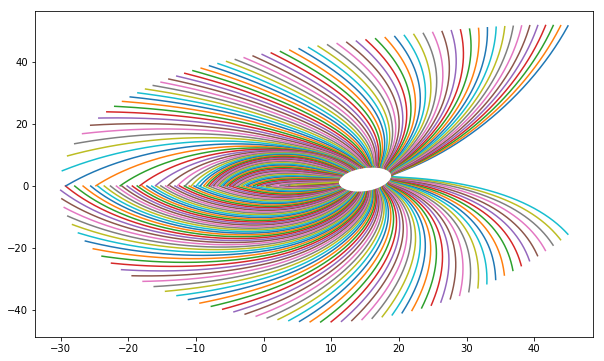

In [3]:
plt.figure(figsize=(10, 6))
for ax in axonal_tracts:
    plt.plot(ax[:, 0], ax[:, 1])

In [4]:
def find_closest_axon(pos_xy, axonal_tracts):
    xneuron, yneuron = pos_xy
    # find the nearest axon to this pixel
    dist = [min((ax[:, 0] - xneuron) ** 2 + (ax[:, 1] - yneuron) ** 2) for ax in axonal_tracts]
    axon_id = np.argmin(dist)

    # find the position on the axon
    ax = axonal_tracts[axon_id]
    dist = (ax[:, 0] - xneuron) ** 2 + (ax[:, 1] - yneuron) ** 2
    pos_id = np.argmin(dist)
    
    # add all positions: from `pos_id` to the optic disc
    return axonal_tracts[axon_id][pos_id:0:-1, :]

In [5]:
def assign_axons(xg, yg, axonal_tracts, engine='joblib', scheduler='threading', n_jobs=-1):
    # Let's say we want a neuron at every pixel location.
    # We loop over all (x, y) locations and find the closest axon:
    pos_xy = [(x, y) for x, y in zip(xg.ravel(), yg.ravel())]
    return p2p.utils.parfor(find_closest_axon, pos_xy, func_args=[axonal_tracts])

In [6]:
xg, yg = np.meshgrid(np.linspace(-10, 10, 50), np.linspace(-10, 10, 50), indexing='xy')

In [7]:
axons = assign_axons(xg, yg, axonal_tracts)

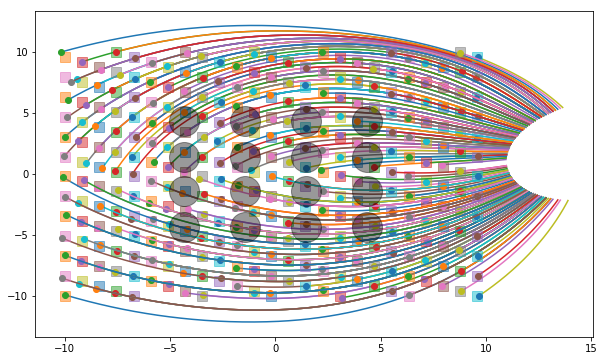

In [8]:
plt.figure(figsize=(10, 6))
draw = -1
for ax, x, y in zip(axons, xg.ravel(), yg.ravel()):
    draw += 1
    if draw % 8 > 0:
        continue
    plt.plot(ax[:, 0], ax[:, 1])
    plt.plot(x, y, 's', markersize=10, alpha=0.5)
    plt.plot(ax[0, 0], ax[0, 1], 'o')
for e in p2p.implants.ArgusI():
    plt.plot(p2p.retina.ret2dva(e.x_center),
             p2p.retina.ret2dva(e.y_center), 'ok', markersize=30, alpha=0.4)

In words: For every axon, there is a function that describes how sensitive the local tissue is. This is a function of the distance from the soma. Possibilites are:
- drops exponentially with distance
- is the Fried function

This function needs to be multiplied with the current spread. Then what do you do?
- You could sum all these values: this is the contribution of this axon at the pixel location of the soma. This is basically the dot product that we implement now.
- You could take the effective current to be the max of this element-wise product.
- You could walk along the axon from the optic disc to the soma. The axon is on if we reach some threshold at any point. This is binary. It's kinda weird, but isn't this how things work?

In [9]:
def axon_sensitivity(dist, rule='decay', decay_const=2.0):
    if rule.lower() == 'decay':
        return np.exp(-dist / decay_const)
    elif rule.lower() == 'fried':
        mu_gauss = p2p.retina.ret2dva(50.0)
        std_gauss = p2p.retina.ret2dva(20.0)
        bell = 0.7 * np.exp(-(dist - mu_gauss) ** 2 / (2 * std_gauss ** 2))
        plateau = 0.3
        soma = np.maximum(mu_gauss - dist, 0)
        return np.maximum(0, bell - 0.001 * dist + plateau - soma)
    else:
        raise ValueError('Unknown rule "%s"' % rule)

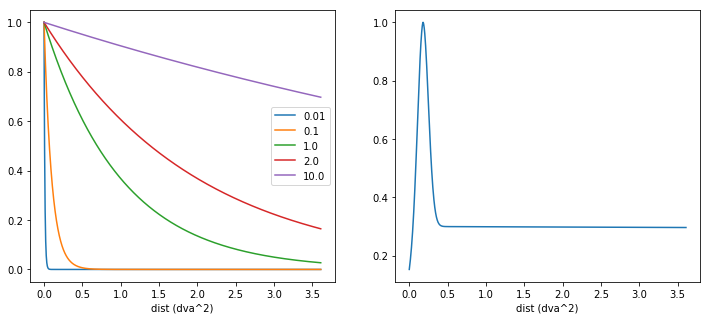

In [10]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
dist = np.linspace(0, p2p.retina.ret2dva(1000), 1000)
for decay_const in [0.01, 0.1, 1.0, 2.0, 10.0]:
    plt.plot(dist, axon_sensitivity(dist, rule='decay', decay_const=decay_const), label=str(decay_const))
plt.legend()
plt.xlabel('dist (dva^2)')

plt.subplot(122)
plt.plot(dist, axon_sensitivity(dist, rule='fried'))
plt.xlabel('dist (dva^2)')

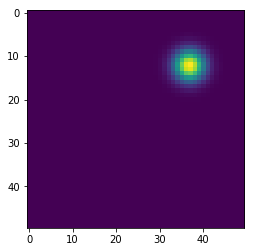

In [11]:
std = 1.0
cs = np.exp(-((xg - 5) ** 2 + (yg - 5) ** 2) / (2 * std ** 2))
plt.imshow(np.flipud(cs))

In [12]:
def get_axon_contribution(axon, cs, xg, yg, sensitivity_rule='fried', activation_rule='max',
                          min_contribution=0.01, tree=None):
    if tree is None:
        from scipy.spatial import cKDTree
        pos_xy = np.vstack((xg.ravel(), yg.ravel())).T
        tree = cKDTree(pos_xy)
        
    # Consider only pixels within the grid
    idx_valid = (axon[:, 0] >= xg.min()) * (axon[:, 0] <= xg.max())
    idx_valid *= (axon[:, 1] >= yg.min()) * (axon[:, 1] <= yg.max())
    
    # For these, find the xg, yg coordinates
    _, idx_cs = tree.query(axon[idx_valid, :])
    if len(idx_cs) == 0:
        return 0, 0.0

    # Drop duplicates
    _, idx_cs_unique = np.unique(idx_cs, return_index=True)
    idx_cs = idx_cs[np.sort(idx_cs_unique)]
    
    # Calculate distance from soma
    if len(idx_cs) > 1:
        dist = np.sqrt(np.diff(xg.ravel()[idx_cs]) ** 2 + np.diff(yg.ravel()[idx_cs]) ** 2)
    else:
        dist = np.array([])
    dist = np.insert(dist, 0, 0.0, axis=0)
    
    # Find effective current
    axon_weights = axon_sensitivity(np.cumsum(dist), rule=sensitivity_rule) * cs.ravel()[idx_cs]
    
    if activation_rule == 'max':
        axon_contribution = axon_weights.max()
    elif activation_rule == 'sum':
        axon_contribution = axon_weights.mean()
    else:
        raise ValueError('Unknown activation rule "%s"' % activation_rule)
    
    if axon_contribution < min_contribution:
        return 0, 0.0
    else:
        return idx_cs[0], axon_contribution

In [13]:
from scipy.spatial import cKDTree
pos_xy = np.vstack((xg.ravel(), yg.ravel())).T
tree = cKDTree(pos_xy)

In [14]:
contrib = p2p.utils.parfor(get_axon_contribution, axons, func_args=[cs, xg, yg],
                           func_kwargs={'activation_rule': 'sum', 'tree': tree}, engine='joblib')

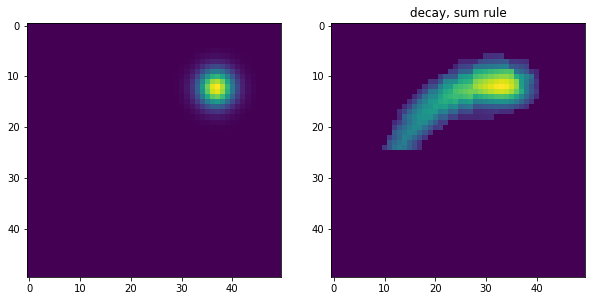

In [15]:
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.imshow(np.flipud(cs))

plt.subplot(122)
ecs = np.zeros_like(cs)
for c in contrib:
    idx, weight = c
    ecs.ravel()[idx] = weight
plt.imshow(np.flipud(ecs))
plt.title('decay, sum rule')

In [16]:
contrib = p2p.utils.parfor(get_axon_contribution, axons, func_args=[cs, xg, yg],
                           func_kwargs={'activation_rule': 'max', 'tree': tree}, engine='joblib')

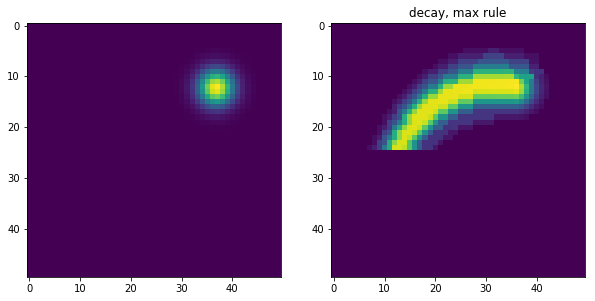

In [17]:
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.imshow(np.flipud(cs))

plt.subplot(122)
ecs = np.zeros_like(cs)
for c in contrib:
    idx, weight = c
    ecs.ravel()[idx] = weight
plt.imshow(np.flipud(ecs))
plt.title('decay, max rule')

In [18]:
contrib = p2p.utils.parfor(get_axon_contribution, axons, func_args=[cs, xg, yg],
                           func_kwargs={'activation_rule': 'sum', 'sensitivity_rule': 'fried',
                                        'tree': tree}, engine='joblib')

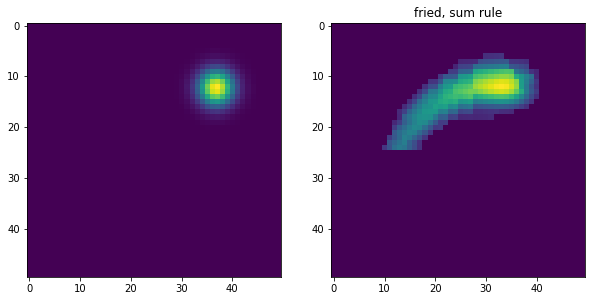

In [19]:
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.imshow(np.flipud(cs))

plt.subplot(122)
ecs = np.zeros_like(cs)
for c in contrib:
    idx, weight = c
    ecs.ravel()[idx] = weight
plt.imshow(np.flipud(ecs))
plt.title('fried, sum rule')

In [20]:
contrib = p2p.utils.parfor(get_axon_contribution, axons, func_args=[cs, xg, yg],
                           func_kwargs={'activation_rule': 'max', 'sensitivity_rule': 'fried',
                                        'tree': tree}, engine='joblib')

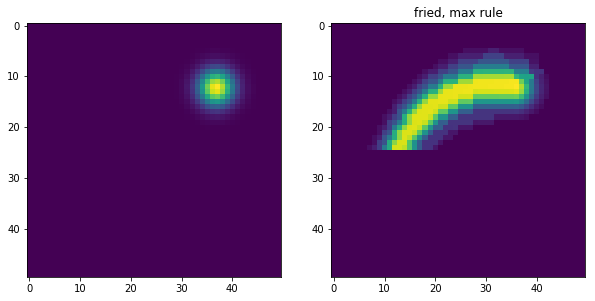

In [21]:
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.imshow(np.flipud(cs))

plt.subplot(122)
ecs = np.zeros_like(cs)
for c in contrib:
    idx, weight = c
    ecs.ravel()[idx] = weight
plt.imshow(np.flipud(ecs))
plt.title('fried, max rule')